# Run script

The model is setup to work with an `Experiment` class, a `multiple_replications` function, and a `results_summary` function.  This code runs the model and generates results. The post processing and display of results is handled by a number of smaller functions.  The model runs in hours.

This notebook demonstrates how to setup and then run the model.  An example script is provided.

## General imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy

## Model imports

In [2]:
from ccu_formatted_code import (
    Experiment, 
    multiple_replications, 
    results_summary, 
    get_experiments, 
    run_all_experiments,
    summary_of_experiments
)

## Setting up and running the model

### Creating an default `Experiment`

An `Experiment` contains all of the configuration for the model. For example, it can be used to vary inter-arrival rates and the mean and standard deviations of the length of stay distributions.  All parameters have default values. We therefore create an instance of `Experiment` and do not pass any parameters:

In [3]:
default_experiment = Experiment()

### Viewing parameters in an `Experiment`

Parameters can easily be viewed as they are attributes of the `Experiment`.

The order of inter-arrival rate means in the list is:

0. A&E
1. Ward
2. Emergency
3. Other hospital
4. X-ray
5. Elective

The mean interarrival rates for all patient types can be viewed raw:

In [4]:
print(default_experiment.interarrival_means)

[22.72, 26.0, 37.0, 47.2, 575.0, 17.91]


or could be manipulated into an easy to view format using `pandas`:

In [5]:
iat_table = pd.DataFrame()

iat_table["source"] = [
    "A&E",
    "Ward",
    "Emergency",
    "Other hospital",
    "X-ray",
    "Elective",
]

iat_table["mean_iat (hrs)"] = default_experiment.interarrival_means

iat_table

,source,mean_iat (hrs)
0,A&E,22.72
1,Ward,26.00
2,Emergency,37.00
3,Other hospital,47.20
4,X-ray,575.00
5,Elective,17.91


To view the capacity of the critical care unit:

In [6]:
default_experiment.num_critical_care_beds

24

There are also a default warm-up and results collection periods (in hours)

In [7]:
print(f"Warm up period: {default_experiment.warm_up_period} hrs")
print(f"Results collection period: {default_experiment.results_collection_period} hrs")

Warm up period: 720 hrs
Results collection period: 8640 hrs


### Creating a custom `Experiment`

#### Example experiment 1: 

We create a new instance of `Experiment` and increase the capacity of the Critical Care Unit to 26 staffed beds.

In [8]:
custom_experiment = Experiment(num_critical_care_beds=26)

As before you can view the number of beds set in the `Experiment`

In [9]:
custom_experiment.num_critical_care_beds

26

#### Example experiment 2:

We create a new instance of `Experiment` and change several parameters.

In this experiment we will:

1. Block arrivals from other hospitals
2. Set the number of critical care beds to 23.
3. Set the intensive cleaning activity to 3 hours.

> We will block arrivals by using an extreme value that results in no arrivals from the other hospitals during the simulated run.

In [10]:
# get the default iat means
# we need to deep copy as LLM used list as parameter instead on None.
# i.e. a mutuable default argument
new_iat_means = deepcopy(default_experiment.interarrival_means)

# other hospitals are at index 3. Set to extreme value
new_iat_means[3] = 100_000_000

blocked_arrivals = Experiment(
    num_critical_care_beds=23,
    interarrival_means=new_iat_means,
    intensive_cleaning_duration=3,
)

In [11]:
blocked_arrivals.interarrival_means

[22.72, 26.0, 37.0, 100000000, 575.0, 17.91]

## Running the model and viewing results

The code below represents a very simple experimental run of the model.  Once an `Experiment` has been created, the multiple replications function is called (passing the `Experiment` and the `num_replications`). This returns a `pandas.DataFrame` of results that shows each KPI by replication.  The `results_summary` function processes the raw replications and returns another `pandas.DataFrame` containing the mean and standard deviation of each KPI across replications. 

In [19]:
# 1. create an experiment
# here we create the default one, but could be customised.
default_experiment = Experiment()

# 2. run multiple independent replications and return results
replications = multiple_replications(default_experiment, num_replications=5)

# 3. summarise the results of the multiple replications
results_table = results_summary(replications)

# 4. show results table (1dp)
results_table.round(1)

,Mean,Standard Deviation
Cancelled Elective Operations,337.8,38.7
Bed Utilization,0.9,0.0
Mean Waiting Time Unplanned,62.5,55.2
Bed Occupancy,21.8,0.5
Patient Count,1650.4,17.8


The variable `replications` is a `pandas.DataFrame`. Each row is a replication and each column a KPI.  In our example script we ran 5 replications.  Therefore the table has 5 rows.  Results are below:

In [13]:
replications

,Replication,Cancelled Elective Operations,Bed Utilization,Mean Waiting Time Unplanned,Bed Occupancy,Patient Count
0,1,353,0.916748,33.047825,22.001956,1665
1,2,357,0.900646,58.780702,21.615514,1631
2,3,375,0.924766,158.213113,22.194387,1644
3,4,275,0.877403,21.348843,21.057679,1639
4,5,329,0.927482,40.876962,22.259566,1673


To visualise the distribution of a KPI over replications you can use standard `matplotlib`. Here we will visualise the distribution of Cancelled Elective Operations and Bed Utilization.
> Example `matplotlib` histogram code here: https://matplotlib.org/stable/gallery/statistics/hist.html#sphx-glr-gallery-statistics-hist-py

In [14]:
replications = multiple_replications(default_experiment, num_replications=100)

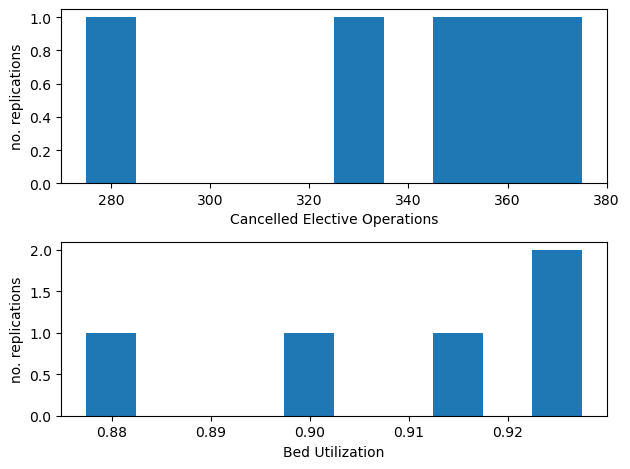

In [15]:
# frequency calculations
counts_ce, bins_ce = np.histogram(replications["Cancelled Elective Operations"])
counts_wt, bins_wt = np.histogram(replications["Bed Utilization"])

fig, axs = plt.subplots(2, 1, tight_layout=True)

# set labels
axs[0].set_ylabel("no. replications")
axs[0].set_xlabel("Cancelled Elective Operations")

axs[1].set_ylabel("no. replications")
axs[1].set_xlabel("Bed Utilization")

# add data to plot
_ = axs[0].hist(bins_ce[:-1], bins_ce, weights=counts_ce)
_ = axs[1].hist(bins_wt[:-1], bins_wt, weights=counts_wt)

## Run multiple pre-set experiments

The LLM was used to generate functions to run and summarise multiple experiments in a batch.  Here we will use three new functions     `get_experiments`, `run_all_experiments`, and `summary_of_experiments`.

> Here the function `get_experiments` creates six experiments that vary the capacity of the CCU between 23 and 28 beds.

In [16]:
# 1. get all of the pre-set experiments
experiments = get_experiments()

# 2. run all experiments in a batch (5 replications each)
all_results = run_all_experiments(experiments, 100)

# 3. display results summary (2dp)
summary = summary_of_experiments(all_results).round(2)

# show results
summary

Running experiment: Experiment_23
Running experiment: Experiment_24
Running experiment: Experiment_25
Running experiment: Experiment_26
Running experiment: Experiment_27
Running experiment: Experiment_28


Experiment_23                    Experiment_24  \
                                       Mean Standard Deviation          Mean   
Cancelled Elective Operations        347.53              71.56        294.91   
Bed Utilization                        0.91               0.03          0.89   
Mean Waiting Time Unplanned           83.37              84.37         46.93   
Bed Occupancy                         20.93               0.71         21.42   
Patient Count                       1627.12              35.16       1627.12   

                                                 Experiment_25  \
                              Standard Deviation          Mean   
Cancelled Elective Operations              73.63        242.11   
Bed Utilization                             0.03          0.87   
Mean Waiting Time Unplanned                51.13         27.01   
Bed Occupancy                               0.77         21.83   
Patient Count                              35.16       1627.12   

                                                 Experiment_26  \
                              Standard Deviation          Mean   
Cancelled Elective Operations              69.43        194.27   
Bed Utilization                             0.03          0.85   
Mean Waiting Time Unplanned                31.80         16.69   
Bed Occupancy                               0.84         22.19   
Patient Count                              35.16       1627.12   

                                                 Experiment_27  \
                              Standard Deviation          Mean   
Cancelled Elective Operations              63.36        152.48   
Bed Utilization                             0.03          0.83   
Mean Waiting Time Unplanned                21.16         10.38   
Bed Occupancy                               0.88         22.48   
Patient Count                              35.16       1627.12   

                                                 Experiment_28  \
                              Standard Deviation          Mean   
Cancelled Elective Operations              56.73        117.92   
Bed Utilization                             0.03          0.81   
Mean Waiting Time Unplanned                13.20          6.45   
Bed Occupancy                               0.94         22.72   
Patient Count                              35.16       1627.12   

                                                  
                              Standard Deviation  
Cancelled Elective Operations              49.52  
Bed Utilization                             0.04  
Mean Waiting Time Unplanned                 7.90  
Bed Occupancy                               0.99  
Patient Count                              35.16

### Saving the results summary to file

The function `summary_of_experiments` returns a `pandas.DataFrame`. The results can be transferred to a file using the following methods:

1. `pandas.DataFrame.to_clipboard()` - copy to clipboard and paste into a spreadsheet program
2. `pandas.DataFrame.to_csv([file_name])` - save to a local Comma Separated Value file that can be opened in a spreadsheet program
3. `pandas.DataFrame.style.to_latex()` - output table in latex format.

In [17]:
# example: save to file
summary.to_csv('batch_results.csv')

In [18]:
# example output as latex
print(summary.style.to_latex(hrules=True, 
                             label="Batch results", 
                             caption="Varying CCU capacity"))

\begin{table}
\caption{Varying CCU capacity}
\label{Batch results}
\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{2}{r}{Experiment_23} & \multicolumn{2}{r}{Experiment_24} & \multicolumn{2}{r}{Experiment_25} & \multicolumn{2}{r}{Experiment_26} & \multicolumn{2}{r}{Experiment_27} & \multicolumn{2}{r}{Experiment_28} \\
 & Mean & Standard Deviation & Mean & Standard Deviation & Mean & Standard Deviation & Mean & Standard Deviation & Mean & Standard Deviation & Mean & Standard Deviation \\
\midrule
Cancelled Elective Operations & 347.530000 & 71.560000 & 294.910000 & 73.630000 & 242.110000 & 69.430000 & 194.270000 & 63.360000 & 152.480000 & 56.730000 & 117.920000 & 49.520000 \\
Bed Utilization & 0.910000 & 0.030000 & 0.890000 & 0.030000 & 0.870000 & 0.030000 & 0.850000 & 0.030000 & 0.830000 & 0.030000 & 0.810000 & 0.040000 \\
Mean Waiting Time Unplanned & 83.370000 & 84.370000 & 46.930000 & 51.130000 & 27.010000 & 31.800000 & 16.690000 & 21.160000 & 10.380000 & 13.200000 & 6.450000